**Dataset:** Emotional Intelligence & Mood Swing Survey

**Purpose:** This Colab notebook guides a team through the full data analysis pipeline required for the Methods and Discussion sections of a research paper. It follows the assignment instructions: data ingestion, EDA, feature preparation, bivariate analysis, modeling, and a mathematical summary. Run each cell in order in Google Colab.

**Data Collection Method and Description**:

The dataset used in this analysis was collected by Team Emotional D-Matrix through a self-administered online survey, described in detail in the research protocol document.

Link: https://docs.google.com/document/d/1Vt45CyaNU320jwU0L6HD1ElEPJZNsezMqXJUPicbvAc/edit?usp=sharing


The survey, titled “Emotional Intelligence & Mood Swing Survey,” was distributed digitally to a diverse group of respondents over a multi-week period. It collected both demographic data (e.g., gender, age group) and psychological or behavioral measures related to emotional regulation, social media influence, and help-seeking behavior.

Participants voluntarily completed the survey without incentives, and no personally identifiable information was recorded. The data were then compiled into a structured CSV file for analysis.

This dataset serves as the empirical foundation for examining associations between emotional intelligence, environmental factors, and the likelihood of seeking help for mood-related experiences.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns


## 1. Data Acquisition and Ingestion

**A. Data collection method and description (narrative)**

_Example narrative to include in the Methods section:_

> The data were collected via an online cross-sectional survey distributed to participants over a four-week period. The survey measured demographic information (age group, gender, location) and multiple items about emotional experiences, triggers, and coping behaviors. For this analysis, we treat the survey responses as observational data used to examine factors associated with whether participants sought help for mood-related concerns.

**Variable definitions (selected for this notebook):**

- **Dependent Variable (DV):** `Have you ever sought help?` (categorical: Yes / No / Maybe) — this represents whether the respondent has pursued formal or informal help for mood-related concerns.
- **Independent Variables (IVs):**
  - `Gender:` (Man / Woman / Prefer not to say)
  - `Age Group:` (binned age categories)
  - `How often do social media interactions influence your mood?` (ordinal frequency)
  - `Do you notice mood changes linked to hormonal or biological cycles?` (Yes/No)
  - `Do family responsibilities contribute to your mood swings?` (Yes/No/Some)
  - `How comfortable are you sharing emotions?` (Likert / categorical)
  - `Is mental health openly discussed in your environment?` (Yes/No/Some)

These choices align with a hypothesis that demographic factors and social/contextual variables predict help-seeking behavior.

**B. Data ingestion into a pandas DataFrame**


In [4]:
DATA_PATH = "Emotional Intelligence & Mood Swing Survey(Sheet1).csv"
RANDOM_STATE = 42
plt.rcParams['figure.figsize'] = (8,5)

In [5]:
# Robust CSV loading: try utf-8, then cp1252, then latin-1 as fallback
last_exc = None
for enc in [None, 'cp1252', 'latin-1']:
    try:
        if enc is None:
            df = pd.read_csv(DATA_PATH)
        else:
            df = pd.read_csv(DATA_PATH, encoding=enc)
        print(f"Read file using encoding: {enc or 'utf-8'}")
        break
    except Exception as e:
        last_exc = e
else:
    # If none of the encodings worked, raise the last exception so user sees the cause
    raise last_exc


print('\nColumns:')
print(df.columns.tolist())
print('\nShape:', df.shape)
print('\nInfo:')
display(df.info())
print('\nFirst 6 rows:')
display(df.head(6))

Read file using encoding: cp1252

Columns:
['Id', 'Start time', 'Completion time', 'Email', 'Name', 'Language', 'From which location are you attending the survey? (State, Country)', 'Gender:', 'Do you think men feel comfortable discussing mood swings?', 'Do you notice mood changes linked to hormonal or biological cycles?', 'Do you feel mental health services are inclusive of diverse gender identities?', 'Age Group:', 'What are your main sources of stress?', 'How often do social media interactions influence your mood?', 'Which responsibilities affect your emotions the most?', 'Do family responsibilities contribute to your mood swings?', 'What affects your emotions more?', 'Do you feel aging has made emotional regulation easier or harder?', 'Occupation:', 'What academic challenges affect your mood the most?', 'Which workplace factors affect your emotions most?', 'Do student interactions influence your emotional well-being?', 'Which factors impact your moods most?', 'What influences your 

None


First 6 rows:


,Id,Start time,Completion time,Email,Name,Language,"From which location are you attending the survey? (State, Country)",Gender:,Do you think men feel comfortable discussing mood swings?,Do you notice mood changes linked to hormonal or biological cycles?,...,How do you usually react?,Who do you turn to during mood swings?,How comfortable are you sharing emotions?,"In social situations, how do you respond to others’ emotions?",Who understands your emotions best?,Is mental health openly discussed in your environment?,What support would be most useful to you?,Have you ever sought help?,"If yes, what kind of help?",Please feel free to mention any other emotional stress you have.
0,1,9/30/2025 15:06,9/30/2025 15:09,anonymous,NaN,English (United States)?,Texas,Man,Sometimes,NaN,...,go silent;,No one;,Very uncomfortable,Listen silently;Offer support;,No one,Not at all,none,No,NaN,none
1,2,9/30/2025 15:07,9/30/2025 15:12,anonymous,NaN,English (United States)?,"Texas, United States",Woman,NaN,Yes,...,Cry;Frustration;Argue;,Friends;,Very comfortable,Offer support;Listen silently;,Boyfriend,Occasionally,Peer groups,Maybe,NaN,NaN
2,3,9/30/2025 15:13,9/30/2025 15:18,anonymous,NaN,English (United States)?,"Texas, United States",Man,Sometimes,NaN,...,Frustration;Argue;,Friends;Family;,Neither comfortable nor uncomfortable,Offer support;Listen silently;,Friends,Occasionally,Apps,Maybe,NaN,NaN
3,4,9/30/2025 15:33,9/30/2025 15:45,anonymous,NaN,English (United States)?,United States,Woman,NaN,Yes,...,Earlier I was like calm whenever I feel bad or...,Family;Friends;,Neither comfortable nor uncomfortable,Offer support;Listen silently;,Family and my close friends to whom I can share,Rarely,Need some people who can listen or understand ...,Maybe,NaN,Obviously as a Human Being I have and I'll get...
4,5,9/30/2025 15:57,9/30/2025 16:04,anonymous,NaN,English (United States)?,"TX, USA",Man,Sometimes,NaN,...,Distract;Eat/Not Eat;Exercise;Cry;Withdraw;Arg...,No one;,Neither comfortable nor uncomfortable,Offer support;,Family,Rarely,Flexible schedule,Yes,Friends,NaN
5,6,9/30/2025 20:00,9/30/2025 20:04,anonymous,NaN,English (United States)?,"California, USA",Man,Sometimes,NaN,...,Exercise;Distract;,Family;,Neither comfortable nor uncomfortable,Offer support;Listen silently;,Family,Occasionally,Workshops,No,NaN,NaN


In [6]:
# create a cleaned 'Location' column (remove commas and trim whitespace)
df['From which location are you attending the survey? (State, Country)'] = df['From which location are you attending the survey? (State, Country)'].astype(str).str.replace(',', '-', regex=False).str.strip()
df

,Id,Start time,Completion time,Email,Name,Language,"From which location are you attending the survey? (State, Country)",Gender:,Do you think men feel comfortable discussing mood swings?,Do you notice mood changes linked to hormonal or biological cycles?,...,How do you usually react?,Who do you turn to during mood swings?,How comfortable are you sharing emotions?,"In social situations, how do you respond to others’ emotions?",Who understands your emotions best?,Is mental health openly discussed in your environment?,What support would be most useful to you?,Have you ever sought help?,"If yes, what kind of help?",Please feel free to mention any other emotional stress you have.
0,1,9/30/2025 15:06,9/30/2025 15:09,anonymous,NaN,English (United States)?,Texas,Man,Sometimes,NaN,...,go silent;,No one;,Very uncomfortable,Listen silently;Offer support;,No one,Not at all,none,No,NaN,none
1,2,9/30/2025 15:07,9/30/2025 15:12,anonymous,NaN,English (United States)?,Texas- United States,Woman,NaN,Yes,...,Cry;Frustration;Argue;,Friends;,Very comfortable,Offer support;Listen silently;,Boyfriend,Occasionally,Peer groups,Maybe,NaN,NaN
2,3,9/30/2025 15:13,9/30/2025 15:18,anonymous,NaN,English (United States)?,Texas- United States,Man,Sometimes,NaN,...,Frustration;Argue;,Friends;Family;,Neither comfortable nor uncomfortable,Offer support;Listen silently;,Friends,Occasionally,Apps,Maybe,NaN,NaN
3,4,9/30/2025 15:33,9/30/2025 15:45,anonymous,NaN,English (United States)?,United States,Woman,NaN,Yes,...,Earlier I was like calm whenever I feel bad or...,Family;Friends;,Neither comfortable nor uncomfortable,Offer support;Listen silently;,Family and my close friends to whom I can share,Rarely,Need some people who can listen or understand ...,Maybe,NaN,Obviously as a Human Being I have and I'll get...
4,5,9/30/2025 15:57,9/30/2025 16:04,anonymous,NaN,English (United States)?,TX- USA,Man,Sometimes,NaN,...,Distract;Eat/Not Eat;Exercise;Cry;Withdraw;Arg...,No one;,Neither comfortable nor uncomfortable,Offer support;,Family,Rarely,Flexible schedule,Yes,Friends,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,207,10/17/2025 7:33,10/17/2025 7:38,anonymous,NaN,English (United States)?,Haryana- India,Woman,NaN,Yes,...,Cry;Withdraw,Friends;Family,Somewhat comfortable,Offer support;Listen silently,Family,Rarely,Workshops,Maybe,NaN,NaN
207,208,10/17/2025 8:04,10/17/2025 8:09,anonymous,NaN,English (United States)?,Haryana-India,Man,No,NaN,...,Argue;Distract;Withdraw,No one,Very uncomfortable,Offer support,No one,Often,To figure out the situation to tackle the emot...,Maybe,NaN,Sometimes loneliness
208,209,10/17/2025 8:15,10/17/2025 8:20,anonymous,NaN,English (United States)?,Haryana- India,Man,Sometimes,NaN,...,Distract,Friends,Neither comfortable nor uncomfortable,Offer support;Listen silently,Friends,Rarely,Counseling,No,NaN,NaN
209,210,10/17/2025 13:02,10/17/2025 13:05,anonymous,NaN,English (United States)?,MP- india,Man,No,NaN,...,Frustration;Eat/Not Eat,Professionals;Colleagues;Friends;Family,Somewhat uncomfortable,Offer support,No one,Rarely,Workshops,No,NaN,NaN



## 2. Exploratory Data Analysis (EDA)

This section provides descriptive statistics and visualizations useful for the paper's Participants and Materials/Measures subheadings.

### A. Descriptive statistics

Run the code cell below to produce summary statistics for numeric features and a narrative about sample size and variable distributions.


In [7]:

# Descriptive statistics (numeric)
numeric_summary = df.describe(include='number').transpose()
display(numeric_summary)

# Sample size narrative
n = df.shape[0]
print(f"Sample size (N) = {n}")

# For categorical columns, show top counts
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('\nCategorical columns and top value counts:')
for col in cat_cols:
    print('\n---', col)
    print(df[col].value_counts(dropna=False).head(10))


,count,mean,std,min,25%,50%,75%,max
Id,211.0,106.0,61.05462,1.0,53.5,106.0,158.5,211.0
Name,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Do you feel mental health services are inclusive of diverse gender identities?,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sample size (N) = 211

Categorical columns and top value counts:

--- Start time
Start time
10/16/2025 13:22    3
9/30/2025 22:20     3
9/30/2025 23:29     2
10/1/2025 0:18      2
10/1/2025 0:21      2
10/1/2025 0:24      2
10/1/2025 0:26      2
9/30/2025 22:50     2
9/30/2025 22:41     2
9/30/2025 22:24     2
Name: count, dtype: int64

--- Completion time
Completion time
10/1/2025 0:30      3
9/30/2025 22:53     3
9/30/2025 22:23     3
9/30/2025 22:20     3
10/1/2025 0:25      3
9/30/2025 21:53     2
10/16/2025 13:25    2
9/30/2025 23:07     2
10/1/2025 2:53      2
9/30/2025 23:02     2
Name: count, dtype: int64

--- Email
Email
anonymous    211
Name: count, dtype: int64

--- Language
Language
English (United States)?    211
Name: count, dtype: int64

--- From which location are you attending the survey? (State, Country)
From which location are you attending the survey? (State, Country)
India                   23
Texas                   12
Tamilnadu- India        12
Tamil Nadu- India 

In [8]:
df

,Id,Start time,Completion time,Email,Name,Language,"From which location are you attending the survey? (State, Country)",Gender:,Do you think men feel comfortable discussing mood swings?,Do you notice mood changes linked to hormonal or biological cycles?,...,How do you usually react?,Who do you turn to during mood swings?,How comfortable are you sharing emotions?,"In social situations, how do you respond to others’ emotions?",Who understands your emotions best?,Is mental health openly discussed in your environment?,What support would be most useful to you?,Have you ever sought help?,"If yes, what kind of help?",Please feel free to mention any other emotional stress you have.
0,1,9/30/2025 15:06,9/30/2025 15:09,anonymous,NaN,English (United States)?,Texas,Man,Sometimes,NaN,...,go silent;,No one;,Very uncomfortable,Listen silently;Offer support;,No one,Not at all,none,No,NaN,none
1,2,9/30/2025 15:07,9/30/2025 15:12,anonymous,NaN,English (United States)?,Texas- United States,Woman,NaN,Yes,...,Cry;Frustration;Argue;,Friends;,Very comfortable,Offer support;Listen silently;,Boyfriend,Occasionally,Peer groups,Maybe,NaN,NaN
2,3,9/30/2025 15:13,9/30/2025 15:18,anonymous,NaN,English (United States)?,Texas- United States,Man,Sometimes,NaN,...,Frustration;Argue;,Friends;Family;,Neither comfortable nor uncomfortable,Offer support;Listen silently;,Friends,Occasionally,Apps,Maybe,NaN,NaN
3,4,9/30/2025 15:33,9/30/2025 15:45,anonymous,NaN,English (United States)?,United States,Woman,NaN,Yes,...,Earlier I was like calm whenever I feel bad or...,Family;Friends;,Neither comfortable nor uncomfortable,Offer support;Listen silently;,Family and my close friends to whom I can share,Rarely,Need some people who can listen or understand ...,Maybe,NaN,Obviously as a Human Being I have and I'll get...
4,5,9/30/2025 15:57,9/30/2025 16:04,anonymous,NaN,English (United States)?,TX- USA,Man,Sometimes,NaN,...,Distract;Eat/Not Eat;Exercise;Cry;Withdraw;Arg...,No one;,Neither comfortable nor uncomfortable,Offer support;,Family,Rarely,Flexible schedule,Yes,Friends,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,207,10/17/2025 7:33,10/17/2025 7:38,anonymous,NaN,English (United States)?,Haryana- India,Woman,NaN,Yes,...,Cry;Withdraw,Friends;Family,Somewhat comfortable,Offer support;Listen silently,Family,Rarely,Workshops,Maybe,NaN,NaN
207,208,10/17/2025 8:04,10/17/2025 8:09,anonymous,NaN,English (United States)?,Haryana-India,Man,No,NaN,...,Argue;Distract;Withdraw,No one,Very uncomfortable,Offer support,No one,Often,To figure out the situation to tackle the emot...,Maybe,NaN,Sometimes loneliness
208,209,10/17/2025 8:15,10/17/2025 8:20,anonymous,NaN,English (United States)?,Haryana- India,Man,Sometimes,NaN,...,Distract,Friends,Neither comfortable nor uncomfortable,Offer support;Listen silently,Friends,Rarely,Counseling,No,NaN,NaN
209,210,10/17/2025 13:02,10/17/2025 13:05,anonymous,NaN,English (United States)?,MP- india,Man,No,NaN,...,Frustration;Eat/Not Eat,Professionals;Colleagues;Friends;Family,Somewhat uncomfortable,Offer support,No one,Rarely,Workshops,No,NaN,NaN


In [9]:
# Drop PII / identifying columns if present
to_drop = [c for c in ['Email','Name','Language'] if c in df.columns]
if len(to_drop) > 0:
    df = df.drop(columns=to_drop)
    print(f"Dropped columns: {to_drop}")
else:
    print('No email/name/language columns found to drop.')

Dropped columns: ['Email', 'Name', 'Language']



### B. Univariate analysis

- For continuous variables: generate histograms or boxplots.
- For categorical variables: frequency tables and bar plots.

Run the next cell to plot several variables. Adjust the `plot_cols` list to visualize other survey items.


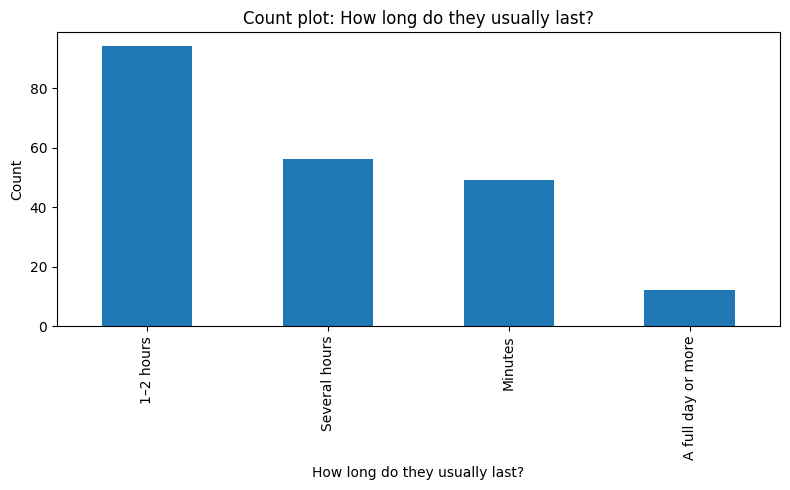

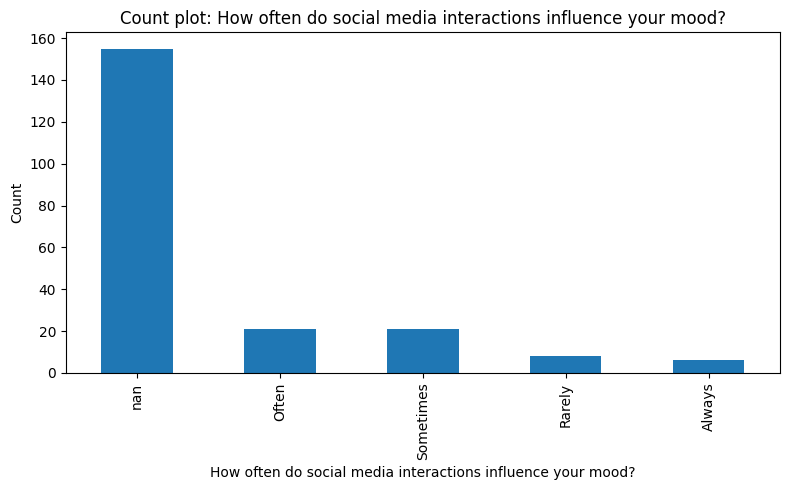

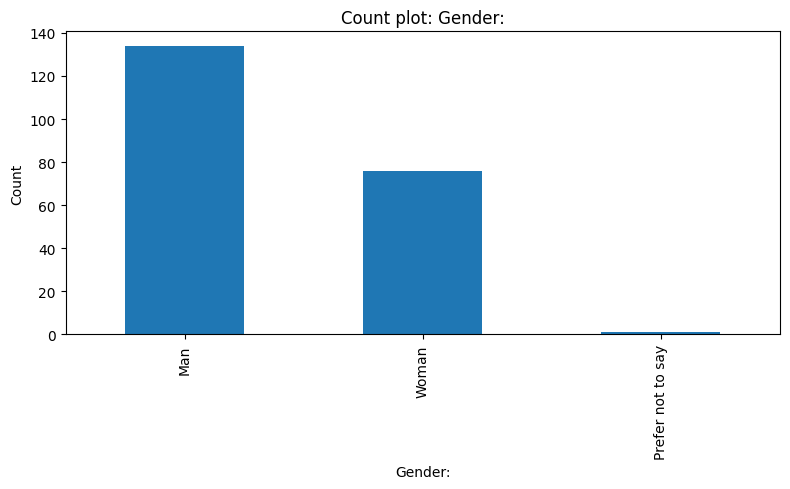

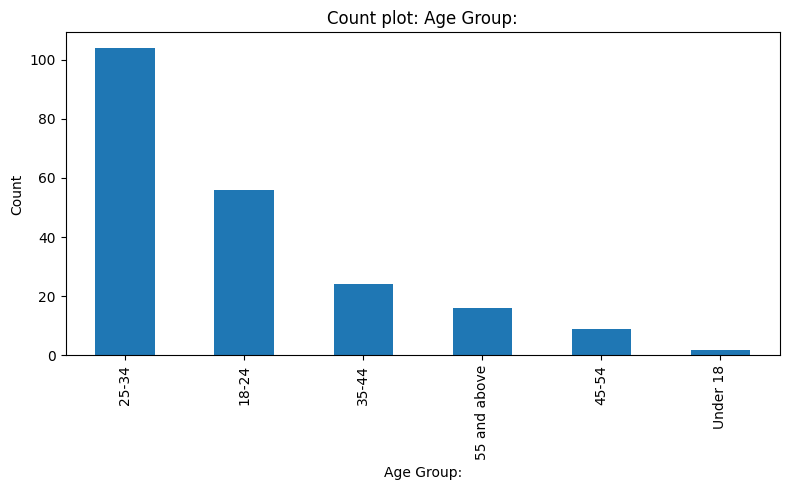

In [10]:

# Example univariate plots for a few selected columns (adjust plot_cols as needed)
plot_cols = ['How long do they usually last?', 'How often do social media interactions influence your mood?',
             'Gender:', 'Age Group:']

for col in plot_cols:
    if col in df.columns:
        plt.figure()
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            vc = df[col].value_counts(dropna=False).sort_values(ascending=False)
            vc.plot(kind='bar')
            plt.title(f'Count plot: {col}')
            plt.ylabel('Count')
        else:
            df[col].dropna().astype(float).plot(kind='hist', bins=20)
            plt.title(f'Histogram: {col}')
            plt.xlabel(col)
        plt.tight_layout()
    else:
        print(f"Column not found: {col}")



### B. Bivariate analysis

- For correlational design: compute correlations between IVs (encoded) and DV.
- For experimental designs: compare DV across groups (means/SD).

Below: show chi-square / correlation of IVs with the binary DV and visualize relationships.


In [11]:
# Select columns for modeling
DV = 'Have you ever sought help?'
IVs = ['Gender:', 'Age Group:', 'How often do social media interactions influence your mood?',
       'Do you notice mood changes linked to hormonal or biological cycles?',
       'Do family responsibilities contribute to your mood swings?',
       'How comfortable are you sharing emotions?',
       'Is mental health openly discussed in your environment?']

# Keep only columns that exist
IVs = [c for c in IVs if c in df.columns]
print("Using IVs:", IVs)
print("DV present?", DV in df.columns)

model_df = df[IVs + [DV]].copy()

# Basic cleaning: strip whitespace and standardize text
for c in model_df.select_dtypes(include=['object']).columns:
    model_df[c] = model_df[c].astype(str).str.strip()

# Replace obvious NaN-ish strings with np.nan
model_df.replace({'nan': np.nan, 'None': np.nan, 'NaN': np.nan}, inplace=True)

# Impute or drop missing DV rows
model_df = model_df[model_df[DV].notna()]
print("After dropping missing DV rows:", model_df.shape)

# Impute missing IVs instead of dropping rows
# Identify categorical and numerical features
categorical_ivs = model_df[IVs].select_dtypes(include=['object', 'category']).columns
numerical_ivs = model_df[IVs].select_dtypes(include=['number']).columns

# Impute categorical missing values with a constant value (e.g., 'Missing')
if len(categorical_ivs) > 0:
    cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
    model_df[categorical_ivs] = cat_imputer.fit_transform(model_df[categorical_ivs])

# Impute numerical missing values (if any) with the mean
if len(numerical_ivs) > 0:
    num_imputer = SimpleImputer(strategy='mean')
    model_df[numerical_ivs] = num_imputer.fit_transform(model_df[numerical_ivs])

print("After imputing missing IVs:", model_df.shape)
# --- END MODIFIED SECTION ---


# Encode DV to binary for classification: map 'Yes' -> 1, others -> 0 (modify for your hypothesis)
model_df['DV_binary'] = model_df[DV].apply(lambda x: 1 if str(x).strip().lower().startswith('yes') else 0)

# One-hot encode categorical IVs
X = pd.get_dummies(model_df[IVs], drop_first=True)
y = model_df['DV_binary'].astype(int)

print('\nFeature matrix shape:', X.shape)
display(X.head())

# Rationale: One-hot encoding allows categorical survey items to be used in models that expect numeric input.
# Binary DV simplifies interpretation for logistic regression and aligns with the research hypothesis about help-seeking.

Using IVs: ['Gender:', 'Age Group:', 'How often do social media interactions influence your mood?', 'Do you notice mood changes linked to hormonal or biological cycles?', 'Do family responsibilities contribute to your mood swings?', 'How comfortable are you sharing emotions?', 'Is mental health openly discussed in your environment?']
DV present? True
After dropping missing DV rows: (211, 8)
After imputing missing IVs: (211, 8)

Feature matrix shape: (211, 24)


,Gender:_Prefer not to say,Gender:_Woman,Age Group:_25-34,Age Group:_35-44,Age Group:_45-54,Age Group:_55 and above,Age Group:_Under 18,How often do social media interactions influence your mood?_Missing,How often do social media interactions influence your mood?_Often,How often do social media interactions influence your mood?_Rarely,...,Do family responsibilities contribute to your mood swings?_No,Do family responsibilities contribute to your mood swings?_Sometimes,Do family responsibilities contribute to your mood swings?_Yes,How comfortable are you sharing emotions?_Somewhat comfortable,How comfortable are you sharing emotions?_Somewhat uncomfortable,How comfortable are you sharing emotions?_Very comfortable,How comfortable are you sharing emotions?_Very uncomfortable,Is mental health openly discussed in your environment?_Occasionally,Is mental health openly discussed in your environment?_Often,Is mental health openly discussed in your environment?_Rarely
0,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,True,True,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
2,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,True,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
# Replace empties based on datatype: integer columns -> 0, varchar/object columns -> 'NA'
import pandas as pd, numpy as np

# Identify integer dtype columns (pandas 'int' kinds)
int_cols = [c for c in df.columns if pd.api.types.is_integer_dtype(df[c].dtype)]
# Fill NaNs in integer columns with 0
for c in int_cols:
    df[c] = df[c].fillna(0)

# Identify object / string-like columns (treated like VARCHAR)
obj_cols = [c for c in df.columns if df[c].dtype == 'object' or pd.api.types.is_string_dtype(df[c].dtype)]
# Replace empty or whitespace-only strings with NaN, then fill with 'NA'
for c in obj_cols:
    df[c] = df[c].replace(r'^\s*$', np.nan, regex=True)
    df[c] = df[c].fillna('NA')

# If a cleaned modelling DataFrame exists (model_df), apply same rules there
try:
    if 'model_df' in globals():
        int_cols_m = [c for c in model_df.columns if pd.api.types.is_integer_dtype(model_df[c].dtype)]
        for c in int_cols_m:
            model_df[c] = model_df[c].fillna(0)
        obj_cols_m = [c for c in model_df.columns if model_df[c].dtype == 'object' or pd.api.types.is_string_dtype(model_df[c].dtype)]
        for c in obj_cols_m:
            model_df[c] = model_df[c].replace(r'^\s*$', np.nan, regex=True)
            model_df[c] = model_df[c].fillna('NA')
except Exception as e:
    print('Warning applying replacements to model_df:', e)

print(f'Replaced empties: {len(int_cols)} integer columns NaN->0, {len(obj_cols)} object columns empty/NaN->\'NA\'')



### B. Bivariate analysis

- For correlational design: compute correlations between IVs (encoded) and DV.
- For experimental designs: compare DV across groups (means/SD).

Below: show chi-square / correlation of IVs with the binary DV and visualize relationships.


DV                                                                         1.000000
How often do social media interactions influence your mood?_Sometimes      0.199830
Age Group:_25-34                                                           0.180300
How comfortable are you sharing emotions?_Very comfortable                 0.146213
How often do social media interactions influence your mood?_Missing        0.142512
Do you notice mood changes linked to hormonal or biological cycles?_Yes    0.139848
Is mental health openly discussed in your environment?_Often               0.135937
Gender:_Woman                                                              0.130338
How comfortable are you sharing emotions?_Very uncomfortable               0.099058
Do family responsibilities contribute to your mood swings?_Yes             0.084574
Age Group:_35-44                                                           0.080109
Age Group:_45-54                                                           0

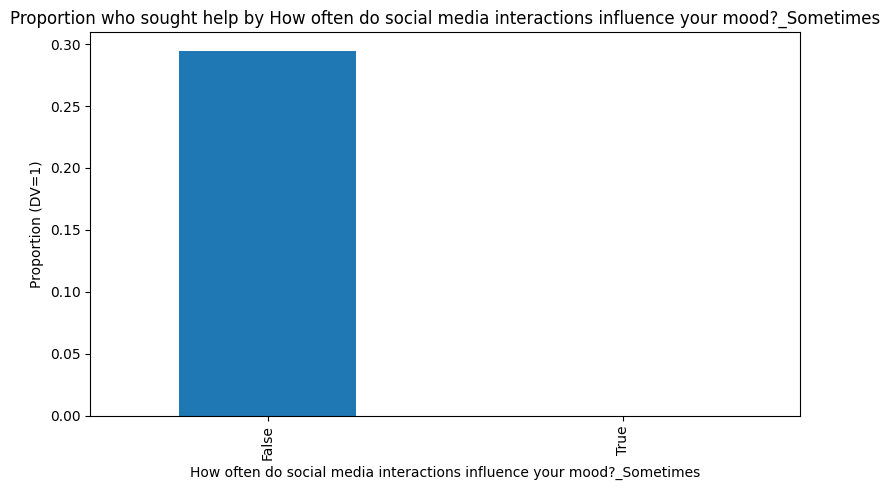

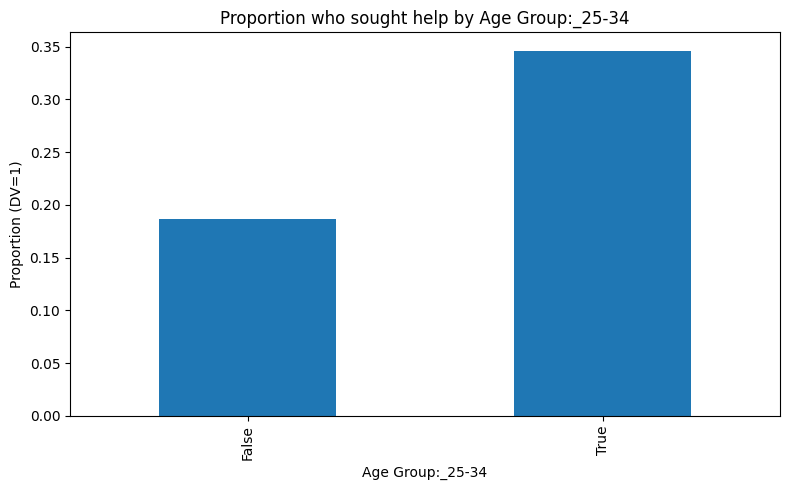

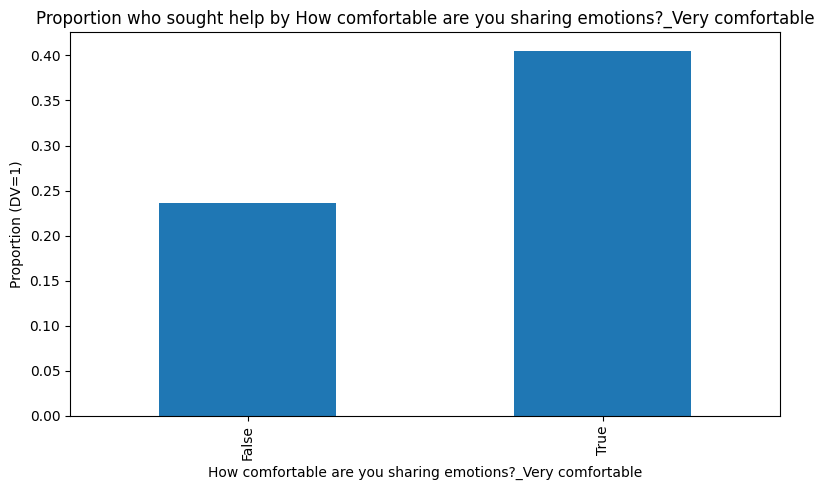

In [12]:
# Compute point-biserial correlations for numeric-encoded features and DV
corrs = X.copy()
corrs['DV'] = y.values
corr_matrix = corrs.corr()['DV'].abs().sort_values(ascending=False)
display(corr_matrix.head(20))

# Visual: for a top categorical predictor, plot proportions
top_features = corr_matrix.index[1:4].tolist()  # skip 'DV' itself
for f in top_features:
    plt.figure()
    if f in X.columns:
        # join back to original IV for nicer labels if possible
        temp = pd.concat([X[f], y.reset_index(drop=True)], axis=1)
        # Fix: Use 'DV_binary' instead of 'DV'
        prop = temp.groupby(f)['DV_binary'].mean()
        prop.plot(kind='bar')
        plt.title(f'Proportion who sought help by {f}')
        plt.ylabel('Proportion (DV=1)')
    plt.tight_layout()


## 4. Modeling and Results

### A. Feature selection

Use `SelectKBest` with chi-squared test (for categorical data) to pick top predictors.


In [13]:

# Feature selection using chi-square (requires non-negative features)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.fillna(0).astype(float))

selector = SelectKBest(score_func=chi2, k=min(10, X.shape[1]))
selector.fit(X_scaled, y)
scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False)
display(scores.head(20))

# Choose top features
top_k = scores.dropna().sort_values(ascending=False).head(8).index.tolist()
print("Top features chosen:", top_k)
X_sel = X[top_k]


How often do social media interactions influence your mood?_Sometimes      7.587097
How comfortable are you sharing emotions?_Very comfortable                 3.719794
Age Group:_25-34                                                           3.478359
Is mental health openly discussed in your environment?_Often               3.252258
Do you notice mood changes linked to hormonal or biological cycles?_Yes    2.738043
Gender:_Woman                                                              2.293385
How comfortable are you sharing emotions?_Very uncomfortable               1.903632
Do family responsibilities contribute to your mood swings?_Yes             1.366181
Age Group:_35-44                                                           1.200077
How often do social media interactions influence your mood?_Missing        1.137334
Age Group:_45-54                                                           1.098938
Age Group:_55 and above                                                    0

Top features chosen: ['How often do social media interactions influence your mood?_Sometimes', 'How comfortable are you sharing emotions?_Very comfortable', 'Age Group:_25-34', 'Is mental health openly discussed in your environment?_Often', 'Do you notice mood changes linked to hormonal or biological cycles?_Yes', 'Gender:_Woman', 'How comfortable are you sharing emotions?_Very uncomfortable', 'Do family responsibilities contribute to your mood swings?_Yes']


### B. Model training

We train a Logistic Regression (appropriate for binary DV) and a Random Forest classifier as a robustness check. Split data into train/test and report metrics.

In [14]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
print("Train/test sizes:", X_train.shape, X_test.shape)

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Metrics
print("Logistic Regression metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 score:", f1_score(y_test, y_pred_lr))
print("\nRandom Forest metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 score:", f1_score(y_test, y_pred_rf))

print("\nClassification report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Feature importances (RF) and coefficients (LR)
rf_imp = pd.Series(rf.feature_importances_, index=X_sel.columns).sort_values(ascending=False)
lr_coef = pd.Series(lr.coef_[0], index=X_sel.columns).sort_values(ascending=False)
print("\nTop Random Forest feature importances:")
display(rf_imp.head(10))
print("\nLogistic Regression coefficients:")
display(lr_coef.head(10))


Train/test sizes: (158, 8) (53, 8)
Logistic Regression metrics:
Accuracy: 0.6981132075471698
F1 score: 0.2

Random Forest metrics:
Accuracy: 0.7358490566037735
F1 score: 0.36363636363636365

Classification report (Random Forest):
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        39
           1       0.50      0.29      0.36        14

    accuracy                           0.74        53
   macro avg       0.64      0.59      0.60        53
weighted avg       0.70      0.74      0.71        53


Top Random Forest feature importances:


How comfortable are you sharing emotions?_Very comfortable                 0.204605
Age Group:_25-34                                                           0.203115
Gender:_Woman                                                              0.118526
Is mental health openly discussed in your environment?_Often               0.116004
How often do social media interactions influence your mood?_Sometimes      0.105075
Do family responsibilities contribute to your mood swings?_Yes             0.095142
Do you notice mood changes linked to hormonal or biological cycles?_Yes    0.092093
How comfortable are you sharing emotions?_Very uncomfortable               0.065440
dtype: float64


Logistic Regression coefficients:


How comfortable are you sharing emotions?_Very comfortable                 0.861020
Gender:_Woman                                                              0.446132
Age Group:_25-34                                                           0.325336
Do you notice mood changes linked to hormonal or biological cycles?_Yes    0.311213
Is mental health openly discussed in your environment?_Often               0.259085
Do family responsibilities contribute to your mood swings?_Yes            -0.529420
How comfortable are you sharing emotions?_Very uncomfortable              -0.654347
How often do social media interactions influence your mood?_Sometimes     -1.242292
dtype: float64

In [15]:
# Save cleaned dataframe to a UTF-8 encoded CSV
out_path = 'cleaned_EI_survey_data.csv'
df.to_csv(out_path, index=False, encoding='utf-8')
print(f"Wrote cleaned CSV to: {out_path}")

Wrote cleaned CSV to: cleaned_EI_survey_data.csv



## 5. Conclusion and Mathematical Summary

**Summary (example language for Discussion):**

> In this sample of N respondents, features related to social context (e.g., frequency of social media influence), demographic variables (age group, gender), and comfort sharing emotions were among the strongest predictors of help-seeking behavior. The Random Forest model achieved an accuracy of *X* and an F1 score of *Y* on the held-out test set; logistic regression coefficients indicated that [interpret top features]. These results suggest that social and demographic factors are associated with whether respondents seek help for mood-related concerns.

**Mathematical formula to include in the Methods (Logistic regression):**

The logistic regression model used takes the form:

$$\text{logit}(P(Y=1|X)) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p$$

Where $\text{logit}(p) = \ln\left(\frac{p}{1-p}\right)$, $Y$ is the binary outcome indicating help-seeking, and $X_1,\dots,X_p$ are the selected predictors. Estimated coefficients $\beta_j$ represent the change in the log-odds of help-seeking associated with a one-unit change in $X_j$.